# Trader Company Method

In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from tc_method import sampler as tc_sampler
from tc_method.interface import TraderCompanyModel

from logging import getLogger, StreamHandler, DEBUG
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)
plt.style.use('dark_background')

In [2]:
@jit(nopython=True)
def generate_autocorrelated_data(rng,n, alpha=0.2):
    x = np.zeros(n)
    epsilon = rng.standard_normal(n)
    for t in range(1, n):
        x[t] = alpha * x[t-1] + epsilon[t]
    return x

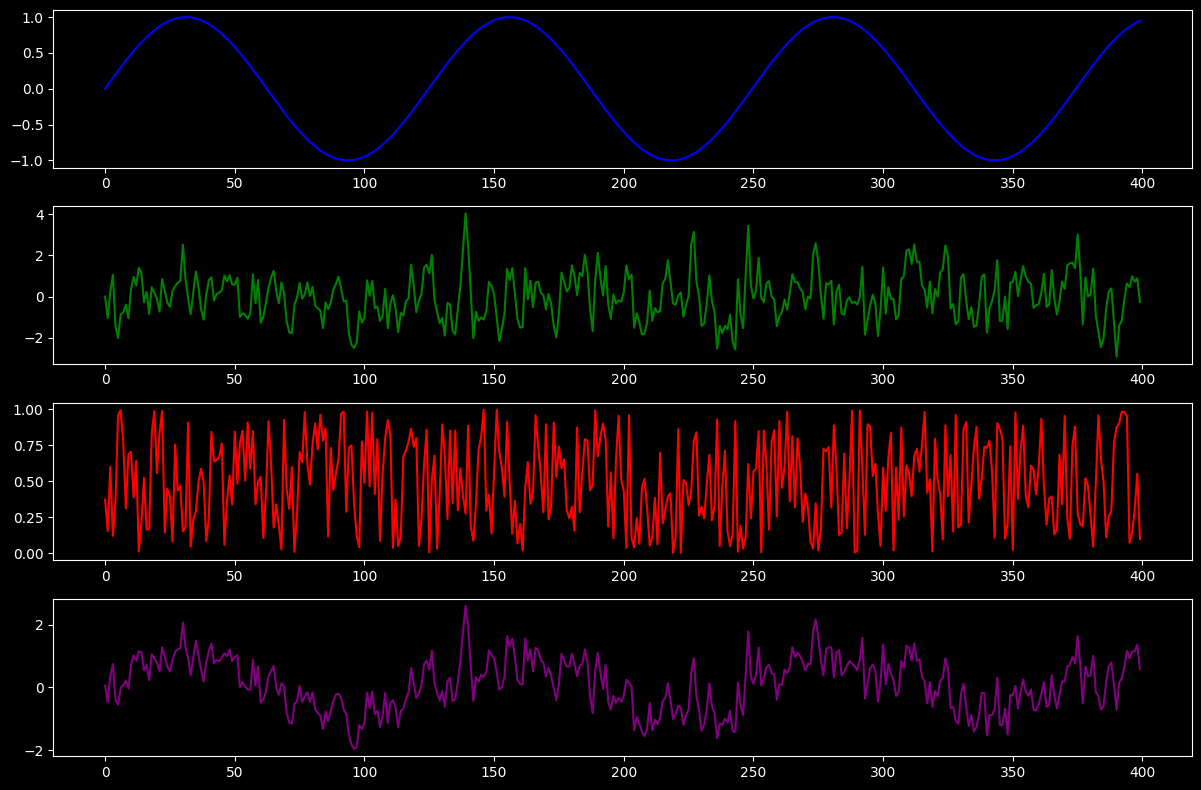

In [3]:
rng = np.random.default_rng(42)
num_samples = 500
num_features = 3
lags = 10

x1 = np.sin(np.linspace(0, 8 * np.pi, num_samples))
x2 = generate_autocorrelated_data(rng,num_samples, alpha=0.5)
x3 = rng.uniform(size=num_samples)

feats = np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1)],axis=1)
target = x1*0.8 + x2*0.5 + x3*0.2 + rng.normal(scale=0.05, size=num_samples) 

train_x,test_x = feats[:400], feats[400 - lags:]
train_y,test_y = target[:400], target[400:]

fig, ax = plt.subplots(4, 1, figsize=(12, 8))

ax[0].plot(train_x[:,0], color='blue')

ax[1].plot(train_x[:,1], color='green')

ax[2].plot(train_x[:,2], color='red')

ax[3].plot(train_y, color='purple')

# ax[4].plot(np.concatenate([np.zeros(max_lags), preds]), color='purple')

fig.tight_layout()

In [7]:
stocks = 3
duration = 100
max_lags = 10
max_feats = 3
traders = 100
q = 0.3
sampler = tc_sampler.NumpyRandomGenerator(seed=1200)
tcm = TraderCompanyModel(stocks, duration, max_lags, max_feats, traders, q)
tcm.train(train_x, train_y,sampler, logger=logger)

Training Trader Company Model...
Train X shape: (400, 3) 
Train Y shape: (400,) 
Initial traders created. Looping...
100%|██████████| 291/291 [00:02<00:00, 127.04it/s]
Training completed.


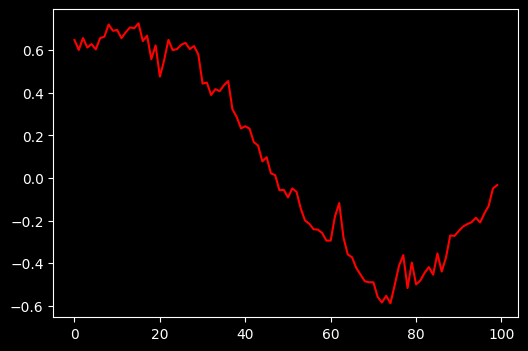

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
preds = tcm.predict(test_x).mean(axis=0)
plt.plot(preds, color='red')

Win rate:  0.64


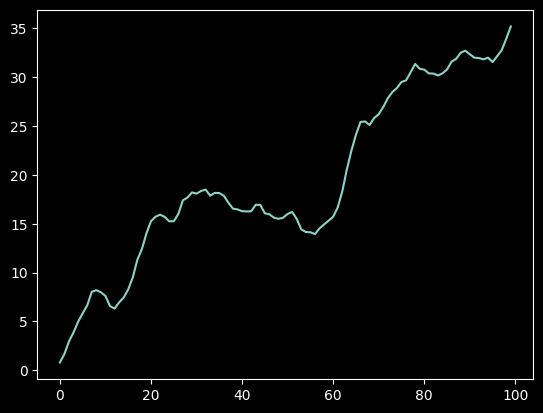

In [9]:
signs_match = np.equal(np.sign(test_y), np.sign(preds))
win_rate = np.where(signs_match, 1, 0).mean()
pnl = np.where(signs_match, np.abs(test_y), -np.abs(test_y)).cumsum()
print("Win rate: ", win_rate)
plt.plot(pnl);

In [15]:
# sampler = OptunaSampler()
# _tcm = TraderCompanyModel(stocks, duration, max_lags, max_feats, traders, q)
# _tcm.train(arr, target, sampler=sampler,verbose=True)